## Import

In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA

## Thu thập dữ liệu

Dữ liệu về phân tích thành phần dinh dưỡng trong thức ăn trên trang wed  của USDA

Link API document: https://fdc.nal.usda.gov/api-guide.html

In [2]:
# all_data = []
# max_page_number = 100
# page = 1
# api_key = 'sfU1TsyAobqAYE5pyGO1Jbhg1GR5kjnVz2HObgVK'
# while page <= max_page_number:
#     url = f'https://api.nal.usda.gov/fdc/v1/foods/list?api_key={api_key}&pageSize=100&pageNumber={page}'
#     response = requests.get(url)
#     data  = response.json()
#     all_data.extend(data)
#     #print(page)
#     page += 1
    
# data_set = pd.DataFrame(all_data)
# data_set.to_json('data.json')

## Khám phá dữ liệu( đủ để xác định câu hỏi)

### Đọc dữ liệu từ file

In [3]:
df = pd.read_json('data.json')


In [4]:
pd.set_option('display.max_colwidth', 200)
df.head()

,fdcId,description,dataType,publicationDate,foodCode,foodNutrients,ndbNumber
0,1104067,100 GRAND Bar,Survey (FNDDS),2020-10-30,91715300.0,"[{'number': '203', 'name': 'Protein', 'amount': 2.5, 'unitName': 'G'}, {'number': '204', 'name': 'Total lipid (fat)', 'amount': 19.3, 'unitName': 'G'}, {'number': '205', 'name': 'Carbohydrate, by ...",NaN
1,1104086,3 MUSKETEERS Bar,Survey (FNDDS),2020-10-30,91726420.0,"[{'number': '203', 'name': 'Protein', 'amount': 2.6, 'unitName': 'G'}, {'number': '204', 'name': 'Total lipid (fat)', 'amount': 12.8, 'unitName': 'G'}, {'number': '205', 'name': 'Carbohydrate, by ...",NaN
2,1104087,3 Musketeers Truffle Crisp Bar,Survey (FNDDS),2020-10-30,91726425.0,"[{'number': '203', 'name': 'Protein', 'amount': 6.41, 'unitName': 'G'}, {'number': '204', 'name': 'Total lipid (fat)', 'amount': 28.8, 'unitName': 'G'}, {'number': '205', 'name': 'Carbohydrate, by...",NaN
3,1099098,"Abalone, cooked, NS as to cooking method",Survey (FNDDS),2020-10-30,26301110.0,"[{'number': '203', 'name': 'Protein', 'amount': 20.4, 'unitName': 'G'}, {'number': '204', 'name': 'Total lipid (fat)', 'amount': 4.59, 'unitName': 'G'}, {'number': '205', 'name': 'Carbohydrate, by...",NaN
4,1099099,"Abalone, floured or breaded, fried",Survey (FNDDS),2020-10-30,26301140.0,"[{'number': '203', 'name': 'Protein', 'amount': 18.2, 'unitName': 'G'}, {'number': '204', 'name': 'Total lipid (fat)', 'amount': 11.4, 'unitName': 'G'}, {'number': '205', 'name': 'Carbohydrate, by...",NaN


### Số dòng và số cột của dữ liệu

In [5]:
df.shape

(10000, 7)

### Số dòng dữ liệu bị lặp

In [6]:
df['fdcId'].duplicated().sum()

0

## Các cột dữ liệu bị thiếu

In [7]:
df.isnull().sum()

fdcId                 0
description           0
dataType              0
publicationDate       0
foodCode           5402
foodNutrients         0
ndbNumber          4603
dtype: int64

### Ý nghĩa của mỗi dòng

Kết quả phân tích thành phần dinh dưỡng của một loại món ăn

### Ý nghĩa của mỗi cột

Mô tả chi tiết về các loại thuộc tính trong dữ liệu: https://fdc.nal.usda.gov/docs/Foundation_Foods_Documentation_Oct2020.pdf

+ fdcId: chuỗi số duy nhất được dùng để dịnh danh các loại món ăn được qui định bởi FoodData Central (FCD)
+ ndbNumber: chuỗi số duy nhất được dùng để dịnh danh các loại món ăn được qui định bởi SR Legacy foods, khác với fcdID
+ description: mô tả loại món ăn gồm: tên, đặc trưng của món ăn (cách thức nấu, màu sắc, ...)
+ dataType: thông tin loại khảo sát tiến hành
+ publicationDate: thời gian công bố dữ dữ liệu phân tích  về loại món ăn
+ foodCode:  chuỗi số duy nhất được dùng để dịnh danh các loại món ăn được qui định bởi The Food and Nutrient Database for Dietary Studies (FNDDS)
+ foodNutrients: kết quả phân tích chi tiết về thành phần dinh dưỡng

### Kiểu dữ liệu của các cột

In [8]:
df.dtypes

fdcId                int64
description         object
dataType            object
publicationDate     object
foodCode           float64
foodNutrients       object
ndbNumber          float64
dtype: object

## Tiền xử lý ( Tách thuộc tính mới từ thuộc tính cũ)


Chuyển thuộc tính "foodNutrients" về các thuộc tính thành phần

In [9]:
food_nutrients_dict = {}
count = 0
keys = []
for foodNutrient in df.foodNutrients:
          
    for component in foodNutrient:

        nutrient_component = f"{component['name']} ({component['unitName'].lower()})"
         
        if nutrient_component not in food_nutrients_dict:
            keys.append(nutrient_component)

            
keys = sorted(keys, reverse = True)
for key in keys:
    food_nutrients_dict[key] = []



In [10]:
len(food_nutrients_dict) # number of new attribute extracted from 'foodNutrients'

220

In [11]:
for col in food_nutrients_dict:
    print(col)

trans-beta-Carotene (ug)
trans-Lycopene (ug)
cis-beta-Carotene (ug)
cis-Lycopene (ug)
cis-Lutein/Zeaxanthin (ug)
Zinc, Zn (mg)
Zeaxanthin (ug)
Water (g)
Vitamin K (phylloquinone) (ug)
Vitamin K (Menaquinone-4) (ug)
Vitamin K (Dihydrophylloquinone) (ug)
Vitamin E, added (mg)
Vitamin E (alpha-tocopherol) (mg)
Vitamin D3 (cholecalciferol) (ug)
Vitamin D2 (ergocalciferol) (ug)
Vitamin D (D2 + D3), International Units (iu)
Vitamin D (D2 + D3) (ug)
Vitamin C, total ascorbic acid (mg)
Vitamin B-6 (mg)
Vitamin B-12, added (ug)
Vitamin B-12 (ug)
Vitamin A, RAE (ug)
Vitamin A, IU (iu)
Valine (g)
Tyrosine (g)
Tryptophan (g)
Total lipid (fat) (g)
Total fat (NLEA) (g)
Total dietary fiber (AOAC 2011.25) (g)
Tocotrienol, gamma (mg)
Tocotrienol, delta (mg)
Tocotrienol, beta (mg)
Tocotrienol, alpha (mg)
Tocopherol, gamma (mg)
Tocopherol, delta (mg)
Tocopherol, beta (mg)
Threonine (g)
Thiamin (mg)
Theobromine (mg)
Sulfur, S (mg)
Sugars, total including NLEA (g)
Sugars, Total NLEA (g)
Sucrose (g)
Stigmas

In [12]:
for foodNutrient in df.foodNutrients:

    sub_keys = []

    for component in foodNutrient:
#         if component['number'] == 268:  ## energy is no longer expressed in kJ as October of 2020
#             continue

        nutrient_component = f"{component['name']} ({component['unitName'].lower()})"
        amount = component['amount']
    
        sub_keys.append(nutrient_component)
        
        food_nutrients_dict[nutrient_component].append(amount)
        
    for key in food_nutrients_dict:
        if key not in sub_keys:
            food_nutrients_dict[key].append(np.NaN)
            
    
            
    

In [13]:
nutrients_df = pd.DataFrame(food_nutrients_dict, index = df['fdcId'])

In [14]:
nutrients_df.head()


,trans-beta-Carotene (ug),trans-Lycopene (ug),cis-beta-Carotene (ug),cis-Lycopene (ug),cis-Lutein/Zeaxanthin (ug),"Zinc, Zn (mg)",Zeaxanthin (ug),Water (g),Vitamin K (phylloquinone) (ug),Vitamin K (Menaquinone-4) (ug),...,14:1 t (g),14:1 c (g),14:1 (g),14:0 (g),13:0 (g),12:1 (g),12:0 (g),11:0 (g),10:0 (g),10-Formyl folic acid (10HCOFA) (ug)
fdcId,,,,,,,,,,,,,,,,,,,,,
1104067,NaN,NaN,NaN,NaN,NaN,0.99,NaN,6.10,6.2,NaN,...,NaN,NaN,NaN,1.030,NaN,NaN,1.440,NaN,0.329,NaN
1104086,NaN,NaN,NaN,NaN,NaN,0.55,NaN,5.80,2.9,NaN,...,NaN,NaN,NaN,0.295,NaN,NaN,0.093,NaN,0.085,NaN
1104087,NaN,NaN,NaN,NaN,NaN,1.83,NaN,0.18,5.8,NaN,...,NaN,NaN,NaN,1.650,NaN,NaN,2.520,NaN,0.365,NaN
1099098,NaN,NaN,NaN,NaN,NaN,0.98,NaN,65.10,31.7,NaN,...,NaN,NaN,NaN,0.028,NaN,NaN,0.000,NaN,0.000,NaN
1099099,NaN,NaN,NaN,NaN,NaN,1.06,NaN,52.40,32.0,NaN,...,NaN,NaN,NaN,0.024,NaN,NaN,0.000,NaN,0.001,NaN


In [15]:
for col in nutrients_df.columns:
    print(col)

trans-beta-Carotene (ug)
trans-Lycopene (ug)
cis-beta-Carotene (ug)
cis-Lycopene (ug)
cis-Lutein/Zeaxanthin (ug)
Zinc, Zn (mg)
Zeaxanthin (ug)
Water (g)
Vitamin K (phylloquinone) (ug)
Vitamin K (Menaquinone-4) (ug)
Vitamin K (Dihydrophylloquinone) (ug)
Vitamin E, added (mg)
Vitamin E (alpha-tocopherol) (mg)
Vitamin D3 (cholecalciferol) (ug)
Vitamin D2 (ergocalciferol) (ug)
Vitamin D (D2 + D3), International Units (iu)
Vitamin D (D2 + D3) (ug)
Vitamin C, total ascorbic acid (mg)
Vitamin B-6 (mg)
Vitamin B-12, added (ug)
Vitamin B-12 (ug)
Vitamin A, RAE (ug)
Vitamin A, IU (iu)
Valine (g)
Tyrosine (g)
Tryptophan (g)
Total lipid (fat) (g)
Total fat (NLEA) (g)
Total dietary fiber (AOAC 2011.25) (g)
Tocotrienol, gamma (mg)
Tocotrienol, delta (mg)
Tocotrienol, beta (mg)
Tocotrienol, alpha (mg)
Tocopherol, gamma (mg)
Tocopherol, delta (mg)
Tocopherol, beta (mg)
Threonine (g)
Thiamin (mg)
Theobromine (mg)
Sulfur, S (mg)
Sugars, total including NLEA (g)
Sugars, Total NLEA (g)
Sucrose (g)
Stigmas

## Câu hỏi đặt ra

--- Quesion ?????? -> What is the formula to caculate the energy from nutrient components in particular food

## Khám phá dữ liệu (để biết cách tách các tập)

In [16]:
nutrients_df['Energy (kcal)'].dtype

dtype('float64')

In [17]:
nutrients_df['Energy (kcal)'].isna().sum()

28

## Tiền xử lý (tách các tập)

In [18]:
# Split dataset into 3 sub dataset: train, validation and test with ratio accordingly is 60%, 20% and 20%
train, val, test = np.split(nutrients_df.sample(frac=1, random_state=0), [int(0.6*len(nutrients_df)), int(0.8*len(nutrients_df))])

In [19]:
# Separate X and y for each sub dataset
X_train = train.drop('Energy (kcal)', axis=1)
y_train = train['Energy (kcal)']

X_val = val.drop('Energy (kcal)', axis=1)
y_val = val['Energy (kcal)']

X_test = test.drop('Energy (kcal)', axis=1)
y_test = test['Energy (kcal)']

## Khám phá dữ liệu (tập huấn luyện)

In [20]:
for dtype in X_train.dtypes:
    print(dtype)

float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64


In [21]:
def missing_ratio(df):
    return (df.isna().mean() * 100).round(1)
def lower_quartile(df):
    return df.quantile(0.25).round(1)
def median(df):
    return df.quantile(0.5).round(1)
def upper_quartile(df):
    return df.quantile(0.75).round(1)
X_train.agg([missing_ratio, 'min', lower_quartile, median, upper_quartile, 'max'])

,trans-beta-Carotene (ug),trans-Lycopene (ug),cis-beta-Carotene (ug),cis-Lycopene (ug),cis-Lutein/Zeaxanthin (ug),"Zinc, Zn (mg)",Zeaxanthin (ug),Water (g),Vitamin K (phylloquinone) (ug),Vitamin K (Menaquinone-4) (ug),...,14:1 t (g),14:1 c (g),14:1 (g),14:0 (g),13:0 (g),12:1 (g),12:0 (g),11:0 (g),10:0 (g),10-Formyl folic acid (10HCOFA) (ug)
missing_ratio,99.9,99.9,99.9,99.9,99.9,2.5,99.9,0.1,19.2,96.1,...,99.900,99.50,81.60,7.5,98.100,99.900,9.8,99.600,11.0,100.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.00,0.00,0.0,0.000,0.000,0.0,0.000,0.0,9.0
lower_quartile,0.8,0.0,0.0,0.0,0.0,0.4,0.0,42.8,0.5,0.0,...,0.000,0.00,0.00,0.0,0.000,0.000,0.0,0.000,0.0,9.0
median,1.5,0.0,0.5,0.0,0.0,0.8,0.5,64.6,2.3,0.0,...,0.000,0.00,0.00,0.1,0.000,0.000,0.0,0.000,0.0,9.0
upper_quartile,2.8,0.0,1.2,0.0,14.2,2.2,58.0,79.7,7.4,2.0,...,0.000,0.10,0.00,0.3,0.000,0.000,0.0,0.000,0.0,9.0
max,5.0,0.0,2.0,0.0,57.0,98.9,229.0,100.0,1640.0,35.7,...,0.047,0.31,1.43,63.4,0.025,0.016,53.4,0.013,5.6,9.0


## Tiền xử lý tập huấn luyện

Với các cột có liên quan đến Energy (kcal), Energy chỉ được đo lường bằng kcal từ tháng 10 năm 2020 và để cho đơn giản, ta chỉ xét đến Energy (kcal) nên ta loại bỏ các cột:
- Energy (kj)
- Energy (Atwater Specific Factors) (kcal)
- Energy (Atwater General Factors) (kcal)

Với các cột có liên quan đến lipit, ta loại bỏ các cột các loại axit béo, chỉ giữ lại các cột số lượng tổng cộng axit béo cuối cùng để giảm bớt nguy cơ overfitting

Với các cột có tỉ lệ dữ liệu bị thiếu trên 25% thì được loại bỏ, các cột bị thiếu còn lại thì sử dụng phương pháp mean để điền dữ liệu bi thiếu

In [22]:
dropped_cols = ['Energy (kj)', 'Energy (Atwater Specific Factors) (kcal)', 'Energy (Atwater General Factors) (kcal)']
X_train.drop(dropped_cols, axis=1, inplace = True)

In [23]:
cols = X_train.columns
for col in cols:
    if re.search(r'[0-9]+:[0-9]+', col) != None:
        X_train.drop(col, axis=1, inplace = True)
        
        

In [24]:
for x in sorted(X_train.isna().mean()):
    print (x)

0.0008333333333333334
0.0008333333333333334
0.001
0.0026666666666666666
0.006333333333333333
0.006666666666666667
0.008333333333333333
0.017666666666666667
0.0205
0.024833333333333332
0.025
0.026
0.026166666666666668
0.0275
0.030333333333333334
0.030666666666666665
0.035
0.037
0.037
0.04033333333333333
0.04033333333333333
0.0425
0.050833333333333335
0.0625
0.06983333333333333
0.07066666666666667
0.079
0.08683333333333333
0.09966666666666667
0.101
0.12183333333333334
0.1495
0.162
0.1625
0.164
0.16516666666666666
0.16633333333333333
0.16833333333333333
0.17283333333333334
0.17683333333333334
0.19166666666666668
0.19216666666666668
0.20766666666666667
0.2205
0.22466666666666665
0.4623333333333333
0.499
0.5561666666666667
0.5701666666666667
0.652
0.6576666666666666
0.658
0.6586666666666666
0.6586666666666666
0.6588333333333334
0.6588333333333334
0.659
0.6591666666666667
0.6596666666666666
0.6613333333333333
0.6615
0.6623333333333333
0.6625
0.6625
0.6626666666666666
0.6631666666666667
0.672

In [25]:
class ColDropper(BaseEstimator, TransformerMixin):
    def __init__(self, missing_ratio_threshold=0.25):
        self.missing_ratio_threshold = missing_ratio_threshold
    
    def fit(self, X_df, y=None):
        self.dropped_cols = set()
        cols = X_df.columns
        total_fatty_acids = ['Fatty acids, total saturated (g)']
        for col in cols:
            if re.search(r'[0-9]+:[0-9]+', col) != None:
                self.dropped_cols.add(col)
                break
            if col not in total_fatty_acids and X_train [f'{col}'].isnull().mean() > self.missing_ratio_threshold : 
                self.dropped_cols.add(col)
                
        return self
    
    def transform(self, X_df, y=None):
        trans_df = X_df.drop(self.dropped_cols, axis = 1)
        return trans_df

In [26]:
process_pipeline = make_pipeline(ColDropper(missing_ratio_threshold=0.25), SimpleImputer(strategy='mean'), StandardScaler())
process_pipeline

Pipeline(steps=[('coldropper', ColDropper()),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [27]:
X_train_processed = process_pipeline.fit_transform(X_train)

In [28]:
X_train_processed.shape
process_pipeline

Pipeline(steps=[('coldropper', ColDropper()),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

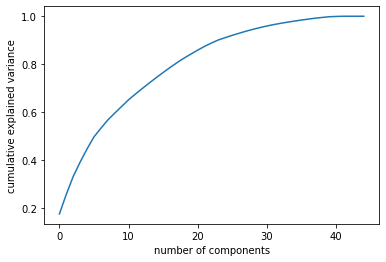

In [29]:
pca = PCA().fit(X_train_processed)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [30]:
process_pipeline_full = make_pipeline(ColDropper(missing_ratio_threshold=0.25), SimpleImputer(strategy='mean'), 
                                      StandardScaler(), PCA(n_components=20))

In [31]:
X_train_processed = process_pipeline_full.fit_transform(X_train)

In [32]:
X_train_processed.shape

(6000, 20)

## Tiền xử lý và mô hình hóa (trên tập validation)